In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import sys
import cv2
import glob
# directory reach
directory = os.path.abspath('')
append_path = os.path.dirname(directory) # go two folders up
from pykinect2 import PyKinectRuntime
from pykinect2 import PyKinectV2

kinectColor = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Color)
import pickle
# setting path
sys.path.append(append_path)
from cv2 import aruco
from datetime import timedelta

from support.pd_support import *
from support.calculations_support import *
from support.generate_ar_data import get_ar_pose_data, detect_ar_markers, add_time_col
from support.camera_calibration import *
from support.ar_calculations import *
from support.mecanum_calculations import *

In [83]:
_pth_calibration = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 20-07-22_10-53-15_690"

In [84]:
""" importing calibration file """

calib_pth = os.path.join(_pth_calibration, "AR_CALIBRATION.msgpack")
_calib_file = open(calib_pth, "rb")
unpacker = mp.Unpacker(_calib_file, object_hook=mpn.decode)
_calib = []
for unpacked in unpacker:
    _calib.append(unpacked)

cameraMatrix = _calib[0][0]
distCoeffs = _calib[0][1]


yPos = 112
xPos = 274

yRes = 736
xRes = 864
scalling = 2
yRes

736

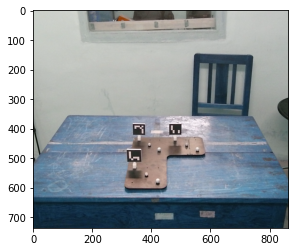

In [85]:
""" importing l frame data """
calib_file = open("new_l_frame2.pickle", "rb")
calib_img = pickle.load(calib_file)
calib_file.close()
plt.imshow(calib_img)

In [86]:
"""detect the aruco markers"""
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
arudo_parameters = aruco.DetectorParameters_create()

corners, ids, rejectedImgPoints = detect_ar_markers(calib_img, arudo_parameters, aruco_dict)

rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(corners, 0.05, cameraMatrix, distCoeffs)
rotation_vector

"""

Idx: 6 - zvector
Idx: 9 - orgin
Idx: 10 - xvector
"""

print(ids)
zvec = translation_vector[0][0]
zvec = np.reshape(zvec, (3, 1))
org = translation_vector[2][0] 
org = np.reshape(org, (3, 1))
xvec = translation_vector[1][0]
xvec = np.reshape(xvec, (3, 1))


translation_vector
zvec
rotMat = calculate_rotmat(xvec, zvec, org)
rotMat

t_xvec = xvec - org 

translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1) # adding the corrections in the new L frame

rotMat.T@t_xvec + translation_correction

[[ 6]
 [10]
 [ 9]]


array([[ 0.19988459],
       [-0.05      ],
       [ 0.045     ]])

In [87]:
# _data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 22-07-22_12-42-02_505" # session 5 test 1
_data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 26-07-22_10-27-13_120" # session 6 test 0
# _data_pth = r"C:\Users\CMC\Dropbox\mira\mira_vellore\splitVideos\ARUCXXXXMARKU010120000000XXXXXXXXX\Session 27-07-22_11-02-21_383" # session 7 test 0

df = get_ar_pose_data(_data_pth, cameraMatrix, distCoeffs, process_raw=True)
df

returning dataframe


,frame_id,x,y,z,yaw,pitch,roll
0,5.0,-0.005015,-0.045195,1.172664,-0.053384,3.029512,0.795643
1,5.0,-0.005337,-0.045384,1.184101,0.071220,-3.062403,-0.731841
2,5.0,-0.005015,-0.045195,1.172664,-0.053384,3.029512,0.795643
3,5.0,-0.005015,-0.045195,1.172664,-0.053384,3.029512,0.795643
4,5.0,-0.005337,-0.045384,1.184101,0.071220,-3.062403,-0.731841
...,...,...,...,...,...,...,...
1023,5.0,0.013014,-0.078591,1.246457,-0.055127,2.969929,0.735210
1024,5.0,0.013026,-0.079034,1.249041,-0.066245,2.992277,0.776526
1025,5.0,0.013026,-0.079034,1.249041,-0.066245,2.992277,0.776526
1026,5.0,0.013014,-0.078591,1.246457,-0.055127,2.969929,0.735210


In [88]:
df = add_time_col(df,  _data_pth)

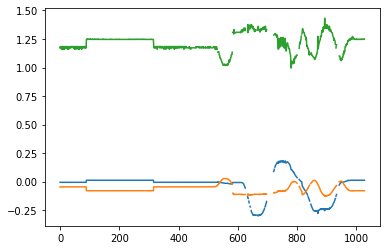

In [89]:
plt.plot(df["x"])
plt.plot(df["y"])
plt.plot(df["z"])

In [90]:

ar_df = pd.DataFrame(columns=["x", "y", "z"])

for i in range(len(df)):
    _val = df[["x", "y", "z"]].iloc[i]
    _val = np.reshape(_val.values, (3, 1))
    _val_t = _val - org
    _xyz = rotMat.T@_val_t + translation_correction
    _xyz = _xyz.reshape(3)
    ar_df.loc[i] = _xyz   
ar_df["time"]= df["time"]

In [91]:
ar_df["time"] = pd.to_datetime(ar_df["time"])

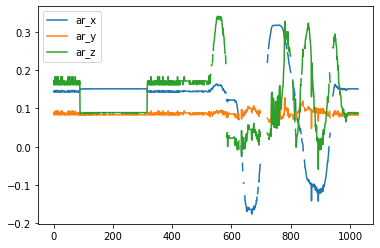

In [92]:
plt.plot(ar_df["x"], label="ar_x")
plt.plot(ar_df["y"], label="ar_y")
plt.plot(ar_df["z"], label="ar_z")
plt.legend()

,frame,seconds,org_x,org_y,org_z,xvec_x,xvec_y,xvec_z,zvec_x,zvec_y,zvec_z,time
0,0,0.00,0.011143,0.149485,-0.024517,0.143142,0.149919,-0.035744,0.033077,0.150649,0.054005,2022-07-26 10:27:35.849
1,1,0.01,0.011144,0.149493,-0.024511,0.143157,0.149925,-0.035728,0.033075,0.150652,0.054001,2022-07-26 10:27:35.859
2,2,0.02,0.011150,0.149491,-0.024513,0.143153,0.149866,-0.035750,0.033079,0.150656,0.054007,2022-07-26 10:27:35.869
3,3,0.03,0.011144,0.149497,-0.024518,0.143150,0.149924,-0.035729,0.033093,0.150635,0.053989,2022-07-26 10:27:35.879
4,4,0.04,0.011151,0.149489,-0.024520,0.143177,0.149888,-0.035746,0.033082,0.150630,0.053976,2022-07-26 10:27:35.889
...,...,...,...,...,...,...,...,...,...,...,...,...
3304,3304,33.04,-0.000707,0.149333,-0.101714,0.131616,0.150364,-0.106933,0.017551,0.150260,-0.022183,2022-07-26 10:28:08.889
3305,3305,33.05,-0.000742,0.149333,-0.101692,0.131609,0.150609,-0.106972,0.017345,0.150243,-0.022308,2022-07-26 10:28:08.899
3306,3306,33.06,-0.000714,0.149316,-0.101726,0.131606,0.150610,-0.106979,0.017545,0.150280,-0.022169,2022-07-26 10:28:08.909
3307,3307,33.07,-0.000716,0.149316,-0.101725,0.131616,0.150367,-0.106934,0.017557,0.150264,-0.022183,2022-07-26 10:28:08.919


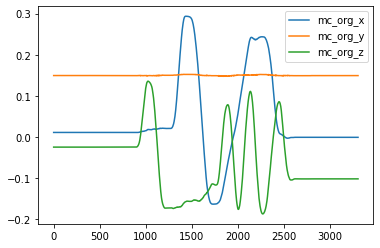

In [93]:
""" getting mc df"""
mc_df, mt_t = read_df_csv("ar_s6_t0.csv")

mc_df = add_datetime_col(mc_df, mt_t, "seconds")
plt.plot(mc_df["org_x"], label="mc_org_x")
plt.plot(mc_df["org_y"], label="mc_org_y")
plt.plot(mc_df["org_z"], label="mc_org_z")
plt.legend()

mc_df

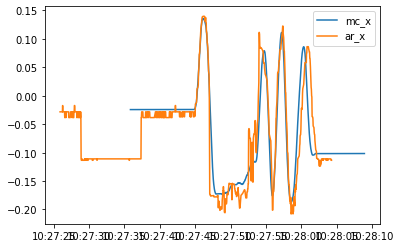

In [94]:
plt.plot(mc_df["time"], mc_df["org_z"], label="mc_x")
plt.plot(ar_df["time"] - timedelta(seconds=8.4), ar_df["z"].interpolate().rolling(3).median()-0.2, label="ar_x")
plt.legend()


In [95]:
"""reading wheels data"""
_csv_pth = os.path.join(_data_pth, "imu01.csv")
cart_df = pd.read_csv(_csv_pth)

cart_df = add_datetime_diff(cart_df, mt_t, "sync", "mils", False)
cart_df

imu_df = cart_df[["sync", "mils", "ax", "ay", "az", "gx", "gy", "gz", "time"]]

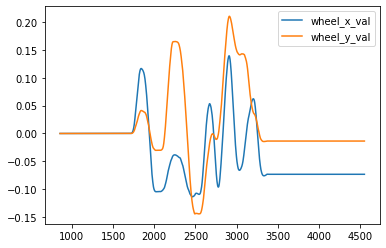

In [96]:
""" this calculates the robots position using mecanum wheels"""

radius = 47.5/1000
lx = 79 #half of the distance between the wheels
ly = 122.5/2

lx = lx/1000
ly = ly/1000



cart_df = set_zero(cart_df, column_name=["e_fr", "e_fl", "e_rr", "e_rl"])
cart_df, c_names = get_angular_velocity(cart_df, column_name=["e_fr", "e_fl", "e_rr", "e_rl"])
cart_df, c_names = get_directional_velocity(cart_df, c_names, radius, lx, ly)
cart_df, c_names = get_position(cart_df)

plt.plot(cart_df["x_val"], label="wheel_x_val")
plt.plot(cart_df["y_val"], label="wheel_y_val")
plt.legend()


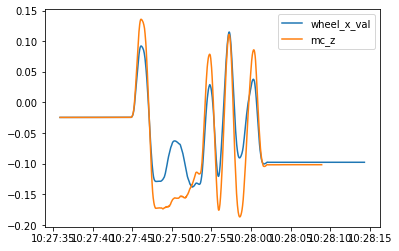

In [106]:
plt.plot(cart_df["time"], cart_df["x_val"]-(cart_df["x_val"].iloc[0] - mc_df["org_z"].iloc[0]), label="wheel_x_val")
plt.plot(mc_df["time"], mc_df["org_z"], label="mc_z")
# plt.plot(ar_df["time"] - timedelta(seconds=8.4), ar_df["z"].interpolate().rolling(3).median()-0.2, label="ar_z") #filtered data
plt.legend()

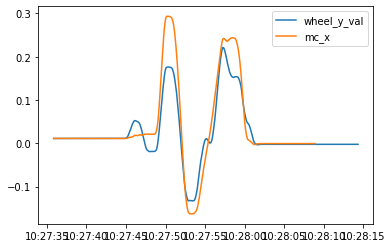

In [104]:
plt.plot(cart_df["time"], cart_df["y_val"]-(cart_df["y_val"].iloc[0] - mc_df["org_x"].iloc[0]), label="wheel_y_val")
plt.plot(mc_df["time"], mc_df["org_x"], label="mc_x")
# plt.plot(ar_df["time"] - timedelta(seconds=8.4), (ar_df["x"].interpolate().rolling(3).median()-0.16)*-1, label="ar_x") #filtered data
plt.legend()

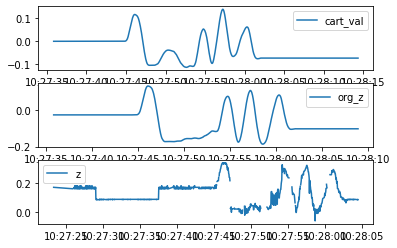

In [99]:
plt.subplot(3, 1, 1)
plt.plot(cart_df["time"],  cart_df["x_val"], label="cart_val")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(mc_df["time"],  mc_df["org_z"], label="org_z")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(ar_df["time"]- timedelta(seconds=8.2),  ar_df["z"], label="z")
plt.legend()

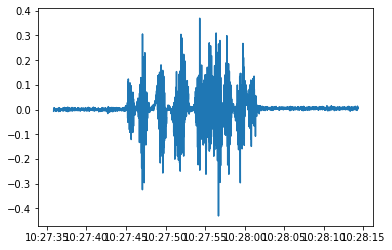

In [100]:
plt.plot(imu_df["time"], imu_df["ax"], label="ax")